# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.276605,False,-1.029570
1,0.431098,False,1.154992
2,3.664006,True,8.606223
3,0.796903,True,5.601567
4,-1.600488,False,-0.106867
...,...,...,...
995,0.292446,True,4.738906
996,1.291597,True,5.401288
997,1.066640,False,0.136621
998,1.441507,True,4.209241


<AxesSubplot:xlabel='v0'>

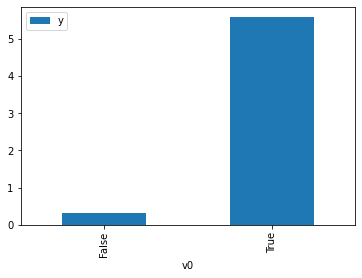

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

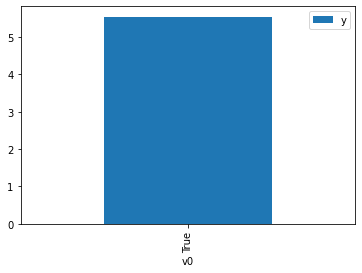

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.283557,False,0.165012,0.079670,12.551845
1,0.695414,False,-0.776181,0.217219,4.603657
2,1.762301,False,0.985568,0.032450,30.816509
3,-0.072787,False,-0.163265,0.559609,1.786963
4,0.601147,False,0.212287,0.250633,3.989905
...,...,...,...,...,...
995,0.240069,False,-0.160846,0.406108,2.462400
996,0.574363,False,0.632563,0.260727,3.835429
997,0.311594,False,0.981055,0.372445,2.684962
998,1.072582,False,1.734856,0.116194,8.606329


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.020043,True,4.331969,0.872686,1.145887
1,1.751840,True,5.360854,0.966893,1.034241
2,0.720224,True,6.953294,0.791021,1.264189
3,0.601784,True,4.258033,0.749605,1.334037
4,2.000279,True,6.004562,0.979496,1.020933
...,...,...,...,...,...
995,-0.150720,True,4.981775,0.402771,2.482797
996,-1.959616,True,5.154716,0.018403,54.340192
997,0.367146,True,6.996826,0.652891,1.531649
998,-0.557470,True,4.300211,0.231555,4.318632


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                          1.229e+04
Date:                Tue, 02 Aug 2022   Prob (F-statistic):                        0.00
Time:                        14:35:41   Log-Likelihood:                         -1430.8
No. Observations:                1000   AIC:                                      2866.
Df Residuals:                     998   BIC:                                      2875.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6621      0.038     17.393      0.000       0.587       0.737
x2             4.9799      0.061     82.260      0.000       4.861       5.099
==============================================================================
Omnibus:                        0.570   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.752   Jarque-Bera (JB):                0.593
Skew:                           0.058   Prob(JB):                        0.743
Kurtosis:                       2.970   Cond. No.                         3.30
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""